# Подключаем нужные библиотеки

In [1]:
import numpy as np
from numpy.linalg import norm
import pickle
import matplotlib.pyplot as plt
import itertools
from scipy.stats import norm as norm_d
from scipy.stats import randint
from scipy.stats import uniform
from scipy.optimize import minimize
import copy
import math
import time
from scipy.optimize import minimize
from scipy.sparse.linalg import svds
from scipy.linalg import svdvals
import scipy
from sklearn.datasets import load_svmlight_file
import pickle
from pathlib import Path
from functions import *
from algorithms import *
from tests import *

%matplotlib inline

# Логистическая регрессия

Для удобства продублируем здесь задачу, которую мы решаем
$$
F(x) = f(x) + R(x) = \frac{1}{m}\sum\limits_{i=1}^m\underbrace{\left(\log\left(1 + \exp\left(-y_i\cdot (Ax)_i\right)\right) + \frac{l_2}{2}\|x\|_2^2\right)}_{f_i(x)} + \underbrace{l_1\|x\|_1}_{R(x)} \to \min\limits_{x\in\mathbb{R}^n}
$$

### Объединим подготовку данных в одну функцию

In [3]:
def prepare_data(dataset):
    filename = "datasets/" + dataset + ".txt"

    data = load_svmlight_file(filename)
    A, y = data[0], data[1]
    m, n = A.shape
    
    if (2 in y) & (1 in y):
        y = 2 * y - 3
    if (2 in y) & (4 in y):
        y = y - 3
    assert((-1 in y) & (1 in y))
    
    sparsity_A = A.count_nonzero() / (m * n)
    return A, y, m, n, sparsity_A

In [4]:
def compute_L(dataset, A):
    filename = "dump/"+dataset+"_L.txt"
    file_path = Path(filename)
    if file_path.is_file():
        with open(filename, 'rb') as file:
            L, average_L, worst_L = pickle.load(file)
    else:
        sigmas = svds(A, return_singular_vectors=False)
        m = A.shape[0]
        L = sigmas.max()**2 / (4*m)
        
        worst_L = 0
        average_L = 0
        denseA = A.toarray()
        for i in range(m):
            L_temp = (norm(denseA[i])**2)*1.0 / 4
            average_L += L_temp / m
            if L_temp > worst_L:
                worst_L = L_temp
        with open(filename, 'wb') as file:
            pickle.dump([L, average_L, worst_L],file)
    return L, average_L, worst_L

## Задание 1. Разреженность матрицы

Рассмотрите датасеты $\texttt{a9a}$, $\texttt{gisette}$, $\texttt{australian}$ и ещё любых 2 датасета на ваш вкус из LIBSVM https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html. Для каждого выбранного датасета проанализируйте какой тип матрицы лучше использовать -- $\texttt{csr_matrix}$ или $\texttt{numpy.ndarray}$ -- чтобы вычислять для данного датасета 

1) полный градиент и

2) стох. градиент (рассмотреть батчи размера 1, 10, 100).

Как видно из формулы для подсчёта градиента 
$$
\nabla f(x) = -\frac{1}{m}\cdot\frac{A^\top y}{1+\exp(y\odot Ax)}  + l_2 x,
$$
и стох. градиента по батчу $S = \{i_1,i_2,\ldots,i_k\}$
$$
\frac{1}{k}\sum\limits_{j=1}^k \nabla f_{i_j}(x) = -\frac{1}{k}\cdot\frac{A_S^\top y_S}{1+\exp(y_S\odot A_Sx)}  + l_2 x,
$$
необходимо выполнить умножение $A^\top$ (или $A_S^\top$) на вектор и умножение $A$ (или $A_S$) на вектор, чтобы посчитать градиент (стох. градиент). Поэтому анализировать предлагается следующим способом: генерируется 5 случайных векторов размерности $n$, а затем в цикле много раз вычисляются градиенты (стох. градиенты) в указанных точках. Количество подсчётов градиентов выбирайте исходя из того, чтобы все умножения при одном из типов хранения матрицы $A$ занимали от 10 до 40 секунд. Для подсчёта стох. градиентов заранее насэмплируйте при помощи функции $\texttt{randint}$ большую выборку элементов от $0$ до $m-1$ (например, выборку размера $10^7$ элементов), а затем вырезайте из неё подряд идущие непересекающиеся куски длиной $r$, где $r$ -- размер батча. Для удобства считайте, что $l_2 = 0$

In [5]:
%%time
dataset = "a9a"
A, y, m, n, sparsity_A = prepare_data(dataset)
print("Число функций в сумме: ", m, ", размерность задачи: ", n)
L, average_L, worst_L = compute_L(dataset, A) #L может зависеть от запуска, поэтому для каждой задачи нужно сохранить свою константу L
print("Константа гладкости всей функции: ", L)
print("Средняя константа гладкости     : ", average_L)
print("Худшая константа гладкости      : ", worst_L)
print("Доля ненулевых элементов: ", sparsity_A)

Число функций в сумме:  32561 , размерность задачи:  123
Константа гладкости всей функции:  1.5719196992226612
Средняя константа гладкости     :  3.467276803535652
Худшая константа гладкости      :  3.5
Доля ненулевых элементов:  0.11275696922074716
CPU times: user 376 ms, sys: 19.4 ms, total: 396 ms
Wall time: 392 ms


По умолчанию матрица $A$ хранится в формате $\texttt{csr_matrix}$

In [5]:
denseA = A.toarray()
print(type(A))
print(type(denseA))

<class 'scipy.sparse._csr.csr_matrix'>
<class 'numpy.ndarray'>


Насэмплируем индексов для батчей

In [6]:
%%time
batch_indices = randint.rvs(low=0, high=m, size=10000000, random_state=None)

CPU times: user 60.5 ms, sys: 60.6 ms, total: 121 ms
Wall time: 118 ms


Пример того, как выглядят тесты для полноградиентного случая

In [7]:
%%time
x = norm_d.rvs(size=n)

CPU times: user 315 µs, sys: 220 µs, total: 535 µs
Wall time: 466 µs


In [8]:
num_of_tests = 600

In [9]:
%%time
for j in range(5):
    x = norm_d.rvs(size=n)
    for i in range(num_of_tests):
        logreg_grad(x, [A, y, 0, True])

CPU times: user 7.65 s, sys: 0 ns, total: 7.65 s
Wall time: 7.65 s


In [10]:
%%time
for j in range(5):
    x = norm_d.rvs(size=n)
    for i in range(num_of_tests):
        logreg_grad(x, [denseA, y, 0, False])

CPU times: user 1min 57s, sys: 59 s, total: 2min 56s
Wall time: 14.9 s


Пример тестов для случая стох. градиентов

In [11]:
batch_size = 1
num_of_tests = 10000

In [12]:
%%time
for j in range(5):
    x = norm_d.rvs(size=n)
    for i in range(num_of_tests):
        batch_ind = batch_indices[i*batch_size:(i+1)*batch_size]
        logreg_grad(x, [A[batch_ind], y[batch_ind], 0, True])

CPU times: user 11.1 s, sys: 4.25 ms, total: 11.1 s
Wall time: 11.1 s


In [13]:
%%time
for j in range(5):
    x = norm_d.rvs(size=n)
    for i in range(num_of_tests):
        batch_ind = batch_indices[i*batch_size:(i+1)*batch_size]
        logreg_grad(x, [denseA[batch_ind], y[batch_ind], 0, False])

CPU times: user 671 ms, sys: 0 ns, total: 671 ms
Wall time: 663 ms


In [14]:
import pandas as pd 


def test_log_reg():
    
    df = pd.DataFrame(columns = [
        'Dataset','M','N','L', 'Worst_L',
        'Sparse GD Time','Dense GD Time',
        'Sparse SGD Time (batch 1)','Dense SGD Time (batch 1)',
        'Sparse SGD Time (batch 10)', 'Dense SGD Time (batch 10)',
        'Sparse SGD Time (batch 100)','Dense SGD Time (batch 100)'])
    
    for dataset_name in ['a9a', 'a5a', 'australian', 'diabetes', 'heart']:
        # load data
        num_of_tests = 100
        A, y, m, n, sparsity_A = prepare_data(dataset_name)
        L, average_L, worst_L = compute_L(dataset_name, A) #L может зависеть от запуска, поэтому для каждой задачи нужно сохранить свою константу L
        # get dense numpy array
        denseA = A.toarray()
        # get indices for stochastic descent
        batch_indices = randint.rvs(low=0, high=m, size=10000000, random_state=42)

        ### test gradient descent
        # sparse matrix case
        t0 = time.time() 
        for j in range(5):
            x = norm_d.rvs(size=n)
            for i in range(num_of_tests):
                logreg_grad(x, [A, y, 0, True])
        t1 = time.time()
        sparse_gd_t = t1 - t0

        # dense matrix case
        t0 = time.time()    
        for j in range(5):
            x = norm_d.rvs(size=n)
            for i in range(num_of_tests):
                logreg_grad(x, [denseA, y, 0, False])
        t1 = time.time()  
        dense_gd_t = t1 -t0

        ### test stochastic gradient descent
        #batch_size = 1
        sparse_sgd_ts =[]
        dense_sgd_ts = []

        for size in [1,10,100]:
            # sparse matrix case
            t0 = time.time() 
            for j in range(5):
                x = norm_d.rvs(size=n)
                for i in range(num_of_tests):
                    idx = batch_indices[i*size:(i+1)*size]
                    logreg_grad(x, [A[idx], y[idx], 0, True])
            sparse_sgd_ts.append(time.time() - t0)

            # dense matrix case
            t0 = time.time() 
            for j in range(5):
                x = norm_d.rvs(size=n)
                for i in range(num_of_tests):
                    idx = batch_indices[i*size:(i+1)*size]
                    logreg_grad(x, [denseA[idx], y[idx], 0, False])
            dense_sgd_ts.append(time.time() - t0)
        
        new_df = pd.DataFrame({'Dataset':dataset_name,'M':m,'N':n,'L':L, 'Worst_L':worst_L,
            'Sparse GD Time':sparse_gd_t,'Dense GD Time':dense_gd_t,
            'Sparse SGD Time (batch 1)':sparse_sgd_ts[0],'Dense SGD Time (batch 1)':dense_sgd_ts[0],
            'Sparse SGD Time (batch 10)':sparse_sgd_ts[1],'Dense SGD Time (batch 10)':dense_sgd_ts[1],
            'Sparse SGD Time (batch 100)':sparse_sgd_ts[2],'Dense SGD Time (batch 100)':dense_sgd_ts[2]}, index=[0])
        
        df = pd.concat([df, new_df], axis=0, ignore_index=True)
    return df

In [15]:
df = test_log_reg()

In [16]:
df

,Dataset,M,N,L,Worst_L,Sparse GD Time,Dense GD Time,Sparse SGD Time (batch 1),Dense SGD Time (batch 1),Sparse SGD Time (batch 10),Dense SGD Time (batch 10),Sparse SGD Time (batch 100),Dense SGD Time (batch 100)
0,a9a,32561,123,1.571920e+00,3.500000e+00,1.344826,2.545378,0.129026,0.007031,0.114000,0.008410,0.121097,0.159117
1,a5a,6414,122,1.574027e+00,3.500000e+00,0.226585,0.427639,0.140342,0.006692,0.110831,0.008140,0.117998,0.137404
2,australian,690,14,7.036285e+06,2.500101e+09,0.079252,0.125372,0.131113,0.006462,0.108189,0.006781,0.116612,0.008815
3,diabetes,768,8,8.606923e+03,1.899885e+05,0.069743,0.010264,0.109924,0.006639,0.109394,0.007509,0.113970,0.009502
4,heart,270,13,2.671068e+04,9.036964e+04,0.064975,0.007912,0.106287,0.007029,0.110317,0.006859,0.113780,0.008307


В целом dense в отличии sparse занял меньше времени на расчеты, кроме первых двух датасетов для GD. Это происходит из-за размерности датасета, т.к. для Dense матрицы требуется меньше памяти для хранения, но нужно проводить больше манипуляций для расчетов.
Число функций m и L-гладкость влияют на время сходимости таким образом, что с увеличением m и L сходимость становится медленнее.
Размер бача должен адаптироваться под задачу, не удается выявить определенные зависимости.

Зафиксируйте здесь результаты своих экспериментов:

## Задание 2. Прокс-оператор

Имплементируйте функцию, вычисляющую $\text{prox}_R(x)$, где $R(x) = \lambda \|x\|_1$, $\lambda \geq 0$. Ваша функция должна брать первым аргументом точку $x$, в которой нужно посчитать прокс, а вторым аргументом -- число $\lambda$.

In [17]:
#напишите код в этой ячейке
def prox_R(x, lamb):
    return np.maximum(np.abs(x) - lamb, 0) * np.sign(x)

Для контроля корректности вызовите фунцию $\texttt{prox}\_\texttt{test}$ из файла $\texttt{tests.py}$. Если какой-то из тестов будет не пройден, то функция вернёт массив $[x, \lambda, \text{prox}_{R}(x)]$, где $x$ и $\lambda$ - параметры, на которых Ваша фукция выдала неправильный ответ, $\text{prox}_{R}(x)$ - это правильный ответ.

In [18]:
prox_test(prox_R)

Все тесты пройдены успешно!


0

## Задание 3. SVRG

Используя заготовку, которая оставлена в файле $\texttt{algorithms.py}$, имплементируйте $\texttt{prox-SVRG}$ с мини-батчингом. Обратите внимание, что в методе можно передавать выборку индексов $\texttt{indices}$ для контроля корректности работы. Однако если передавать $\texttt{None}$ в качестве $\texttt{indices}$, то в методе новые индексы тоже будут сэмплироваться не на каждй итерации. Сделано это осознанно: можн гораздо быстрее насэмплировать i.i.d. выборку размера, скажем, $N$ за один вызов функции, чем сэмплировать $N$ раз подряд выборку размера $1$. Это можно наглядно проверить. Для начала загрузим датасет $\texttt{a9a}$.

In [6]:
%%time
dataset = "a9a"
A, y, m, n, sparsity_A = prepare_data(dataset)
print("Число функций в сумме: ", m, ", размерность задачи: ", n)
L, average_L, worst_L = compute_L(dataset, A) #L может зависеть от запуска, поэтому для каждой задачи нужно сохранить свою константу L
print("Константа гладкости всей функции: ", L)
print("Средняя константа гладкости     : ", average_L)
print("Худшая константа гладкости      : ", worst_L)
print("Доля ненулевых элементов: ", sparsity_A)

Число функций в сумме:  32561 , размерность задачи:  123
Константа гладкости всей функции:  1.5719196992226612
Средняя константа гладкости     :  3.467276803535652
Худшая константа гладкости      :  3.5
Доля ненулевых элементов:  0.11275696922074716
CPU times: user 440 ms, sys: 10.6 ms, total: 451 ms
Wall time: 433 ms


В нём 32561 функция в сумме. Предположим, что мы запускаем $\texttt{prox-SGD}$ с размером батча $r = 1$ на $1000000$ итераций, что примерно 30 проходов по датасету, то есть не так уж и много. Давайте просэмплируем выборку размера $1000000$ за один раз и $1000000$ раз просэмплируем выборку размера $1$. Сначала просэмплируем сразу большую выборку.

In [20]:
%%time
randint.rvs(low=0, high=m, size=1000000, random_state=None)

CPU times: user 7.4 ms, sys: 8.74 ms, total: 16.1 ms
Wall time: 11.3 ms


array([ 2586, 18665,  8113, ...,  8604, 24168, 27762])

На это ушло 1-3 секунды (зависит от мощности компьютера). А теперь рассмотрим второй вариант. Запустите следущую ячейку, а затем можете сходить заварить себе чай...

In [21]:
%%time
for i in range(1000000):
    randint.rvs(low=0, high=m, size=1, random_state=None)

CPU times: user 1min 8s, sys: 0 ns, total: 1min 8s
Wall time: 1min 8s


Таким образом, выгоднее сэмплировать сразу много индексов, чтобы не терять много времени на сэмплирования.

Для проверки корректности работы метода предлагается воспользоваться заранее сгенерированной выборкой индексов и запустить для неё $\texttt{prox-SVRG}$ со следующими параметрами

In [22]:
with open("dump/test_indices_a9a.txt", 'rb') as file:
    test_indices = pickle.load(file)

filename=dataset+"_x_init_all_ones"
x_init = np.ones(n)
l2 = L / 10000
l1 = L / 1000
batch_size = 10
M = int(2*m/batch_size)
gamma = 1.0/(6*(L+l2))
x_star = None
f_star = None
S = 3
save_info_period = 100

#эти 2 параметра выставите в соответствии с вашими экспериментами по разреженности матрицы
sparse_full = False
sparse_stoch = False

In [23]:
%%time
res = svrg(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, M=M, max_t=np.inf,
     batch_size=batch_size, indices=test_indices, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)


CPU times: user 2.32 s, sys: 2.73 s, total: 5.05 s
Wall time: 1.52 s


Запустите функцию, тестирующую корректность работы

In [24]:
svrg_test(res)

Тесты пройдены!


0

Для удобства тестирования и построения графиков методов Вам предлагается использовать следующие функции.

Данная функция нужна для того, чтобы получить доступ к результатам работы метода.

In [19]:
def read_results_from_file(filename, method, args):
    if method == 'SVRG':
        with open('dump/'+filename+'_SVRG_gamma_'+str(args[0])+"_l2_"+str(args[1])+"_l1_"+str(args[2])+"_num_of_epochs_"
                  +str(args[3])
              +"_epoch_length_"+str(args[4])+"_batch_size_"+str(args[5])+".txt", 'rb') as file:
            return pickle.load(file)
    if method == "SGD_const_stepsize":
        with open('dump/'+filename+'_SGD_const_stepsize_gamma_'+str(args[0])+"_l2_"+str(args[1])+"_l1_"+str(args[2])
                  +"_num_of_epochs_"+str(args[3])+"_batch_size_"+str(args[4])+".txt", 'rb') as file:
            return pickle.load(file)
    if method == "SGD_decr_stepsize":
        with open('dump/'+filename+'_SGD_decr_stepsize_gamma_'+str(args[0][0])+"_decr_period_"
                  +str(args[0][1])+"_decr_coeff_"+str(args[0][2])
                  +"_l2_"+str(args[1])+"_l1_"+str(args[2])
                  +"_num_of_epochs_"+str(args[3])+"_batch_size_"+str(args[4])+".txt", 'rb') as file:
            return pickle.load(file)
    if method == "prox-GD":
        with open('dump/'+filename+'_prox-GD_gamma_'+str(args[0])+"_l2_"+str(args[1])+"_l1_"+str(args[2])
                  +"_num_of_epochs_"+str(args[3])+".txt", 'rb') as file:
            return pickle.load(file)
    if method == "GD":
        with open('dump/'+filename+'_GD_gamma_'+str(args[0])+"_l2_"+str(args[1])+"_l1_"+str(args[2])
                  +"_num_of_epochs_"+str(args[3])+".txt", 'rb') as file:
            return pickle.load(file)
    if method == "FISTA":
        with open('dump/'+filename+'_FISTA'+"_l2_"+str(args[0])+"_l1_"+str(args[1])
                  +"_num_of_epochs_"+str(args[2])+".txt", 'rb') as file:
            return pickle.load(file)

Эта функция нужна, чтобы выгрузить решение задачи для данного датасета при заданных $l_2$ и $l_1$.

In [14]:
def save_solution(dataset, l2, l1, x_star, f_star):
    filename = "dump/"+dataset+"_solution_l2_"+str(l2)+"_l1_"+str(l1)+".txt"
    with open(filename, 'wb') as file:
        pickle.dump([x_star, f_star], file)

Эта функция нужна, чтобы выгрузить решение задачи для данного датасета при заданных $l_2$ и $l_1$.

In [12]:
def read_solution(dataset, l2, l1):
    with open('dump/'+dataset+'_solution_l2_'+str(l2)+"_l1_"+str(l1)+".txt", 'rb') as file:
        return pickle.load(file)

Теперь запустите $\texttt{prox-SVRG}$ с теми же параметрами, но на бОльшее число эпох. Сохраните $x^*$ и $f(x^*)$. Параметр $\texttt{indices}$ выставляйте равным $\texttt{None}$. Параметры $l_2$ и $l_1$ выбирайте согласно PDF-документу с заданиями. Посчитайте количество ненулевых значений в найденном решении.

In [29]:
# ваш код здесь
# задать параметры
l2 = L / 10000
l1 = L / 1000
batch_size = 10
M = int(2*m/batch_size)
gamma = 1.0/(6*(L+l2))
x_star = None
f_star = None
S = 500
save_info_period = 100

#эти 2 параметра выставите в соответствии с вашими экспериментами по разреженности матрицы
sparse_full = False
sparse_stoch = False

In [30]:
%%time
res = svrg(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, M=M, max_t=np.inf,
     batch_size=batch_size, indices=None, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)
print("Найденное значение: ", res['func_vals'][-1])
print("Процент ненулевых координат в найденном решении: ", np.count_nonzero(res['last_iter'])/n)

Найденное значение:  0.35785681111419754
Процент ненулевых координат в найденном решении:  0.2845528455284553
CPU times: user 6min 13s, sys: 7min 57s, total: 14min 10s
Wall time: 3min 57s


In [31]:
# ваш код здесь
# сохранить решение x_star и f_star
save_solution(dataset, l2, l1, res['last_iter'], res['func_vals'][-1])

Сравните найденное значение с тем, которое выдаёт стандартный солвер (сравните результаты для $l_1 = 0$ и $l_1 = \frac{L}{1000}$)

In [32]:
%%time
l1=0
res = svrg(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, M=M, max_t=np.inf,
     batch_size=batch_size, indices=None, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)
print("Найденное значение: ", res['func_vals'][-1])
print("Процент ненулевых координат в найденном решении: ", np.count_nonzero(res['last_iter'])/n)

Найденное значение:  0.32527803015192985
Процент ненулевых координат в найденном решении:  1.0
CPU times: user 6min 11s, sys: 8min 5s, total: 14min 16s
Wall time: 3min 56s


In [33]:
%%time
param = [A, y, l2, True, l1]
res_solver = minimize(F, x_init, args = param, jac=logreg_grad_plus_lasso, 
                      options={'maxiter':5000, 'disp':True}, tol=1e-10)

print(res_solver.fun)

         Current function value: 0.325278
         Iterations: 565
         Function evaluations: 611
         Gradient evaluations: 599
0.3252780301519581
CPU times: user 15.4 s, sys: 41.6 s, total: 57 s
Wall time: 4.85 s


In [34]:
%%time
l1 = L / 1000
param = [A, y, l2, True, l1]
res_solver = minimize(F, x_init, args = param, jac=logreg_grad_plus_lasso, 
                      options={'maxiter':5000, 'disp':True}, tol=1e-10)

print(res_solver.fun)

         Current function value: 0.357986
         Iterations: 185
         Function evaluations: 254
         Gradient evaluations: 248
0.35798556341690463
CPU times: user 6.12 s, sys: 16.9 s, total: 23 s
Wall time: 2.1 s


In [35]:
%%time
l1 = L / 1000
A_aus, y, m, n, sparsity_A = prepare_data('australian')
x_init_aus = np.ones(n)
param = [A_aus, y, l2, True, l1]
res_solver = minimize(F, x_init_aus, args = param, jac=logreg_grad_plus_lasso, 
                      options={'maxiter':5000, 'disp':True}, tol=1e-10)

print(res_solver.fun)

         Current function value: 0.343745
         Iterations: 67
         Function evaluations: 90
         Gradient evaluations: 90
0.3437451264136039
CPU times: user 61.8 ms, sys: 28 µs, total: 61.8 ms
Wall time: 57.8 ms


In [36]:
%%time
# задать параметры
l2 = L / 10000
l1 = L / 1000
batch_size = 100
M = int(2*m/batch_size)
gamma = 1.0/(6*(L+l2))
x_star = None
f_star = None
S = 150000
save_info_period = 1000

#эти 2 параметра выставите в соответствии с вашими экспериментами по разреженности матрицы
sparse_full = False
sparse_stoch = False

res = svrg(filename=filename, x_init=x_init_aus, A=A_aus, y=y, gamma=gamma, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, M=M, max_t=np.inf,
     batch_size=batch_size, indices=None, save_info_period=save_info_period, 
     x_star=None, f_star=None)
print("Найденное значение: ", res['func_vals'][-1])
print("Процент ненулевых координат в найденном решении: ", np.count_nonzero(res['last_iter'])/n)


Найденное значение:  35822.72780636599
Процент ненулевых координат в найденном решении:  1.0
CPU times: user 8min 41s, sys: 23min 44s, total: 32min 25s
Wall time: 2min 42s


Теперь повторите эксперимент с $S = 3$, но передайте туда найденные при помощи $\texttt{prox-SVRG}$ $x^*$ и $f(x^*)$ в качестве $\texttt{x}{\_}\texttt{star}$ и $\texttt{f}{\_}\texttt{star}$

In [37]:
A, y, m, n, sparsity_A = prepare_data('a9a')
filename=dataset+"_x_init_all_ones"
x_init = np.ones(n)
l2 = L / 10000
l1 = L / 1000
batch_size = 10
M = int(2*m/batch_size)
gamma = 1.0/(6*(L+l2))
x_star = read_solution(dataset, l2, l1)[0]
f_star = read_solution(dataset, l2, l1)[1]
S = 3
save_info_period = 100

#эти 2 параметра выставите в соответствии с вашими экспериментами по разреженности матрицы
sparse_full = False
sparse_stoch = False

In [38]:
%%time
res = svrg(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, M=M, max_t=np.inf,
     batch_size=batch_size, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

CPU times: user 2.02 s, sys: 2.97 s, total: 4.99 s
Wall time: 1.4 s


Следующая функция позволяет строить графики

In [17]:
def make_plots(args):
    supported_modes_y = ['squared_distances', 'func_vals']
    supported_modes_x = ['time', 'data_passes', 'iters']
    
    dataset = args[0]
    filename = args[1]
    mode_y = args[2]
    mode_x = args[3]
    figsize = args[4]
    fontsize = args[5]
    title = args[6]
    methods = args[7]
    
    assert(mode_y in supported_modes_y)
    assert(mode_x in supported_modes_x)
    
    plt.figure(figsize=figsize)
    plt.title(title, fontsize=fontsize)
    marker = itertools.cycle(('+', 'd', 'x', 'o', '^', 's', '*', 'p', '<', '>', '^'))
    
    num_of_methods = len(methods)
    for idx, method in enumerate(methods):
        res = read_results_from_file(filename, method[0], method[1])
        if method[3] == None:
            length = len(res['iters'])
        else:
            length = method[3]
        plt.semilogy(res[mode_x][0:length], res[mode_y][0:length] / res[mode_y][0], linewidth=2, marker=next(marker), 
            markersize = 20, 
            markevery=range(-idx*int(length/(10*num_of_methods)), len(res[mode_x][0:length]), int(length/10)), 
            label = method[0]+method[2])
        
    
    plt.legend(bbox_to_anchor=(2,1), loc="upper right", fontsize=fontsize)
    if mode_x == 'time':
        plt.xlabel(r"Time, $s$", fontsize=fontsize)
    if mode_x == 'sampled_grads':
        plt.xlabel(r"Number of sampled gradients / number of data samples", fontsize=fontsize)
    if mode_x == 'iters':
        plt.xlabel(r"Number of iterations", fontsize=fontsize)
    if mode_y == 'squared_distances':
        plt.ylabel(r"$\frac{||x^k - x^*||_2^2}{||x^0 - x^*||_2^2}$", fontsize=fontsize)
    if mode_y == 'func_vals':
        plt.ylabel(r"$\frac{f(x^k)-f(x^())}{f(x^0)-f(x^*)}$", fontsize=fontsize)
    
    plt.xticks(fontsize=fontsize)
    _ = plt.yticks(fontsize=fontsize)

In [40]:
dataset = "a9a"
filename=dataset+"_x_init_all_ones"
l2 = L / 10000
l1 = L / 1000
batch_size = 10
gamma = 1.0/(6*(L+l2))

#это массив с методами и их парамтерами, для которых мы хотим построить графики
#в кждом массиве внутри этого массива есть 4 элемента
#первый элемент -- название метода
#второй элемент -- [параметры, чтобы открыть файл]
#третий элемент -- метка, которая будет использоваться в легенде графика (чтобы понимать, чему отвечает та или иная траектория)
#четвёртый элемент -- None или целое число, если Вы хотите обрезать график справа
methods = [
         ['SVRG', [gamma, l2, l1, 3, int(2*m/10), 10], 
           ' третий аргумент', None],
]
mode_y = 'squared_distances'
mode_x = 'time'
figsize = (12, 8)
fontsize = 20
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))

args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]

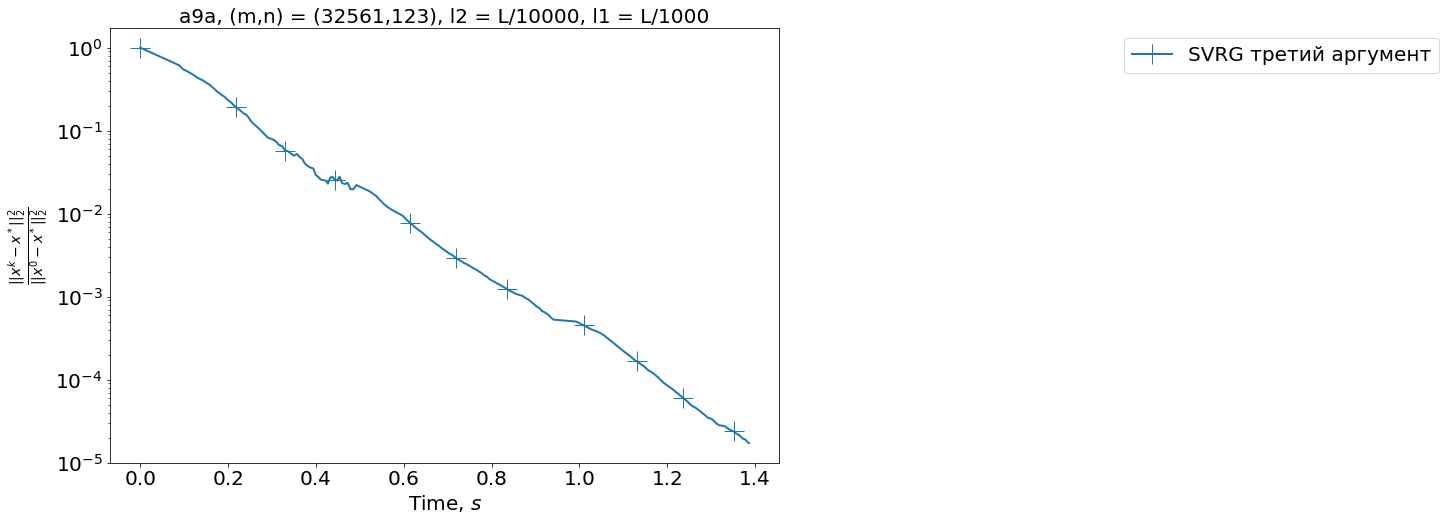

In [41]:
make_plots(args=args_for_plots)

Попробуйте разные размеры батчей и разные $l_2$ и $l_1$, как это указано в задании

In [42]:
for batch_size in [1, 10, 100]:
    dataset = "a9a"
    filename=dataset + "_x_init_all_ones"
    test_indices = None
    x_init = np.ones(n)
    l2 = L / 10000
    l1 = L / 1000
    batch_size = batch_size
    M = int(2*m/batch_size)
    gamma = 1.0/(6*(L+l2))
    x_star = read_solution(dataset, l2, l1)[0]
    f_star = read_solution(dataset, l2, l1)[1]
    S = 50
    save_info_period = 50
    sparse_full = False
    sparse_stoch = False
    res = svrg(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, M=M, max_t=np.inf,
     batch_size=batch_size, indices=None, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)
    save_solution(dataset, l2, l1, res['last_iter'], res['func_vals'][-1])

FileNotFoundError: [Errno 2] No such file or directory: 'dump/a9a_x_init_all_ones_SVRG_gamma_0.10592154712642346_l2_0.001571919699222661_l1_0.001571919699222661_num_of_epochs_40_epoch_length_65122_batch_size_1.txt'

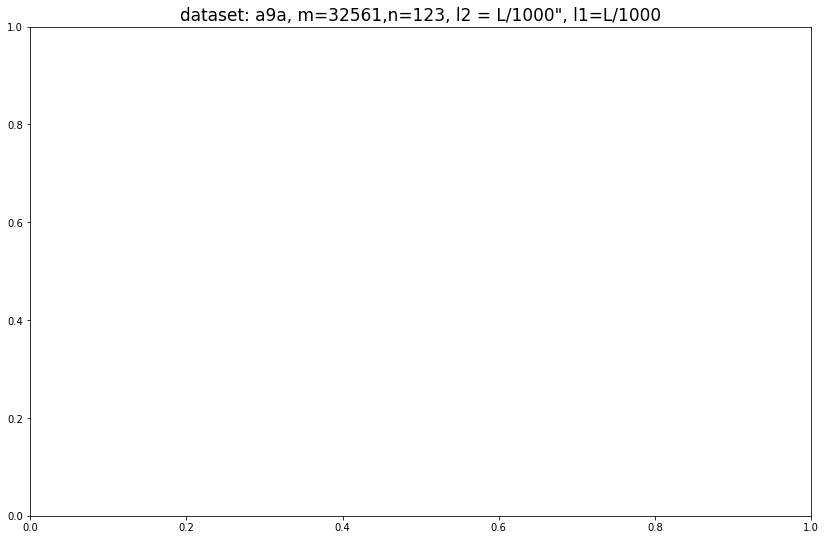

In [45]:
r_1 = 1
r_10 = 10
r_100 = 100
gamma = 1.0/(6*(L+l2))
methods = [
        ['SVRG', [gamma, l2, l1, S, int(2*m/r_1), r_1], 
           f', batch_size = {r_1}', None],
        ['SVRG', [gamma, l2, l1, S, int(2*m/r_10), r_10], 
           f', batch_size = {r_10}', None], # l2 = L / 10000, l1 = L / 1000, r_10=10, S=50
        ['SVRG', [gamma, l2, l1, S, int(2*m/r_100), r_100], 
           f', batch_size = {r_100}', None],
]
mode_y = 'squared_distances'
mode_x = 'time'
figsize = (14, 9)
fontsize = 17
title = f'dataset: {dataset}, m={m},n={n}, l2 = L/{str(int(L/l2))}", l1=L/{str(int(L/l1))}'

args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args=args_for_plots)
plt.show()

In [44]:
for l2 in[L/100000,L/10000,L/1000]:
    dataset = "a9a"
    filename=dataset+"_x_init_all_ones"
    test_indices = None
    x_init = np.ones(n)
    l1 = L / 1000
    batch_size = 100
    M = int(2*m/batch_size)
    gamma = 1.0/(6*(L+l2))
    S = 40
    save_info_period = 100
    sparse_full = False
    sparse_stoch = False
    res = svrg(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, M=M, max_t=np.inf,
     batch_size=batch_size, indices=None, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)
    save_solution(dataset, l2, l1, res['last_iter'], res['func_vals'][-1])

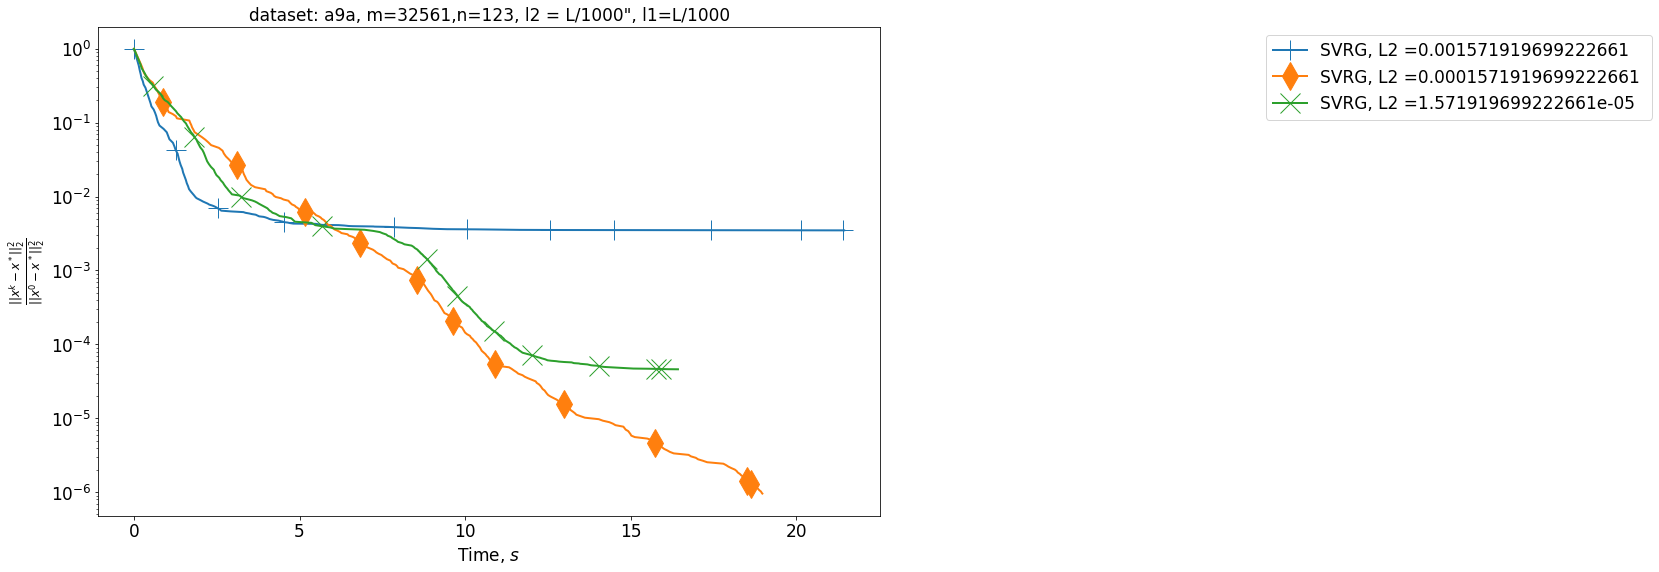

In [49]:
l21 = L/1000
l22 = L/10000
l23 = L/100000
dataset = "a9a"
filename=dataset+"_x_init_all_ones"
batch_size = 100
g_1000 = 1.0/(6*(L+l21))
g_10000 = 1.0/(6*(L+l22))
g_100000 = 1.0/(6*(L+l23))
methods = [
        ['SVRG', [g_1000, l21, l1, S, int(2*m/batch_size), 100], 
           f', L2 ={l21} ', None],
        ['SVRG', [g_10000, l22, l1, S, int(2*m/batch_size), 100], 
               f', L2 ={l22} ', None],
        ['SVRG', [g_100000, l23, l1, S, int(2*m/batch_size), 100], 
               f', L2 ={l23} ', None],
]
mode_y = 'squared_distances'
mode_x = 'time'
figsize = (14, 9)
fontsize = 17
title = f'dataset: {dataset}, m={m},n={n}, l2 = L/{str(int(L/l2))}", l1=L/{str(int(L/l1))}'

make_plots(args=[dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods])
plt.show()

## Задание 4. SGD

Имплементируйте $\texttt{prox-SGD}$ с мини-батчингом и постоянным шагом. Имплементируйте $\texttt{prox-SGD}$ с мини-батчингом и периодически уменьшающимся шагом.

In [6]:
with open("dump/test_indices_a9a.txt", 'rb') as file:
    test_indices = pickle.load(file)

filename=dataset+"_x_init_all_ones"
x_init = np.ones(n)
l2 = L / 10000
l1 = L / 1000
batch_size = 10
M = int(2*m/batch_size)
gamma = 1.0/(6*(L+l2))
x_star = None
f_star = None
S = 3
save_info_period = 100

#эти 2 параметра выставите в соответствии с вашими экспериментами по разреженности матрицы
sparse_full = True
sparse_stoch = False

In [7]:
%%time
res = sgd_const_stepsize(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, max_t=np.inf,
     batch_size=batch_size, indices=test_indices, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

CPU times: user 1.06 s, sys: 25.3 ms, total: 1.09 s
Wall time: 1.08 s


Запустите функцию, тестирующую корректность работы

In [8]:
sgd_const_test(res)

Тесты пройдены!


0

In [9]:
with open("dump/test_indices_a9a.txt", 'rb') as file:
    test_indices = pickle.load(file)

filename=dataset+"_x_init_all_ones"
x_init = np.ones(n)
l2 = L / 10000
l1 = L / 1000
batch_size = 10
M = int(2*m/batch_size)
gamma = 1.0/(6*(L+l2))
gamma_schedule = [gamma, 1, 0.5]
x_star = None
f_star = None
S = 10
save_info_period = 100

#эти 2 параметра выставите в соответствии с вашими экспериментами по разреженности матрицы
sparse_full = True
sparse_stoch = False

In [10]:
%%time
res = sgd_decr_stepsize(filename=filename, x_init=x_init, A=A, y=y, gamma_schedule=gamma_schedule, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, max_t=np.inf,
     batch_size=batch_size, indices=test_indices, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

CPU times: user 2.98 s, sys: 15.9 ms, total: 3 s
Wall time: 2.99 s


Запустите функцию, тестирующую корректность работы

In [11]:
sgd_decr_test(res)

Тесты пройдены!


0

Если тесты пройдены успешно, то выполните эксперименты, описанные в задании.

In [15]:
for alpha in [1.0,0.1,0.01]:
    dataset = "a9a"
    filename=dataset+"_x_init_all_ones"
    x_init = np.ones(n)
    l2 = L / 10000
    l1 = L / 1000
    batch_size = 100
    M = int(2*m/batch_size)
    gamma = alpha/((L+l2))
    x_star = read_solution(dataset, l2,l1)[0]
    f_star = read_solution(dataset, l2,l1)[1]
    S = 100
    save_info_period = 100
    sparse_full = False
    sparse_stoch = False
    res = sgd_const_stepsize(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, max_t=np.inf,
     batch_size=batch_size, indices=test_indices, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)
    save_solution(dataset, l2, l1, res['last_iter'], res['func_vals'][-1])

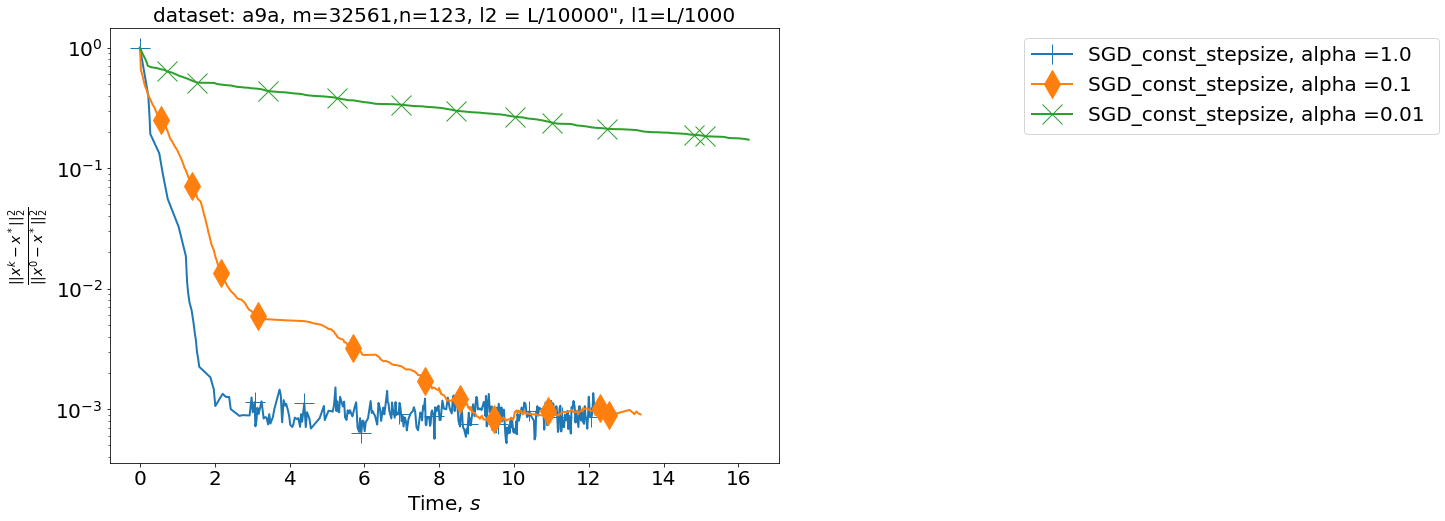

In [20]:
dataset = "a9a"
filename=dataset+"_x_init_all_ones"
l2 = L / 10000
l1 = L / 1000
batch_size = 100
M = int(2*m/batch_size)
g1 = 1.0/((L+l2))
g2 = 0.1/((L+l2))
g3 = 0.01/((L+l2))

methods = [
        ['SGD_const_stepsize', [g1, l2, l1, S, 100], 
           f', alpha ={1.0} ', None],
        ['SGD_const_stepsize', [g2, l2, l1, S, 100], 
           f', alpha ={0.1} ', None], 
        ['SGD_const_stepsize', [g3, l2, l1, S, 100], 
           f', alpha ={0.01} ', None],
]
mode_y = 'squared_distances'
mode_x = 'time'
figsize = (12, 8)
fontsize = 20
title = f'dataset: {dataset}, m={m},n={n}, l2 = L/{str(int(L/l2))}", l1=L/{str(int(L/l1))}'

args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args=args_for_plots)
plt.show()

In [21]:
for schedule in [[gamma, 10, 0.8],[gamma, 10, 0.5],[gamma, 5, 0.8],[gamma, 5, 0.5]]:
    filename=dataset
    x_init = np.ones(n)
    l2 = L / 10000
    l1 = L / 1000
    batch_size = 100
    M = int(2*m/batch_size)
    gamma = 0.01/(6*(L+l2))
    gamma_schedule = schedule
    x_star = read_solution(dataset, l2,l1)[0]
    f_star = read_solution(dataset, l2,l1)[1]
    S = 100
    save_info_period = 100
    sparse_full = False
    sparse_stoch = False
    res = sgd_decr_stepsize(filename=filename, x_init=x_init, A=A, y=y, gamma_schedule=gamma_schedule, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, max_t=np.inf,
     batch_size=batch_size, indices=test_indices, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

FileNotFoundError: [Errno 2] No such file or directory: 'dump/a9a_SGD_decr_stepsize_gamma_0.001060168669868512_decr_period_10_decr_coeff_0.8_l2_0.0001571919699222661_l1_0.001571919699222661_num_of_epochs_100_batch_size_100.txt'

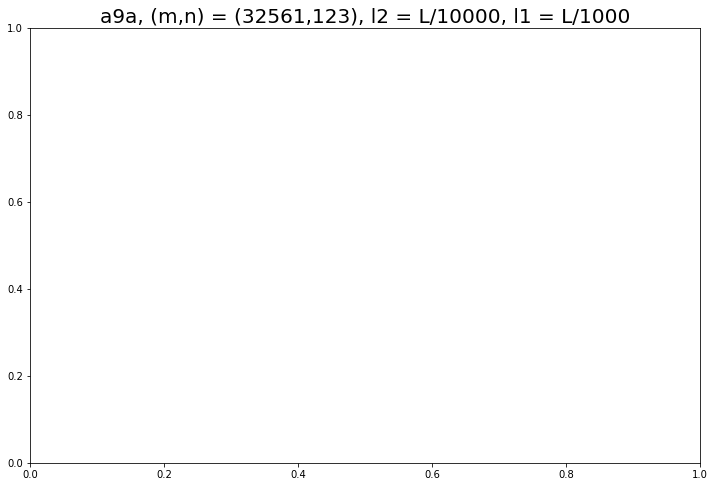

In [23]:
filename=dataset
l2 = L / 10000
l1 = L / 1000
batch_size = 100
M = int(2*m/batch_size)
gamma = 0.01/(6*(L+l2))
S = 100
save_info_period = 100

methods = [
        ['SGD_decr_stepsize', [[gamma, 10, 0.8], l2, l1, S, 100], 
           f', T ={10}, b = {0.8} ', None],
        ['SGD_decr_stepsize', [[gamma, 10, 0.5], l2, l1, S, 100], 
           f', T ={10}, b = {0.5} ', None],
        ['SGD_decr_stepsize', [[gamma, 5, 0.8], l2, l1, S, 100], 
           f', T ={5}, b = {0.8} ', None],
        ['SGD_decr_stepsize', [[gamma, 5, 0.5], l2, l1, S, 100], 
           f', T ={5}, b = {0.5} ', None],
]
mode_y = 'squared_distances'
mode_x = 'time'
figsize = (12, 8)
fontsize = 20
# title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))
title = f'dataset: {dataset}, m={m},n={n}, l2 = L/{str(int(L/l2))}", l1=L/{str(int(L/l1))}'

args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args=args_for_plots)
plt.show()

In [25]:
for r in [1, 10, 100]:
    filename=dataset
    x_init = np.ones(n)
    l2 = L / 10000
    l1 = L / 1000
    batch_size = r
    M = int(2*m/batch_size)
    gamma = 0.01/(6*(L+l2))
    gamma_schedule = [gamma, 10, 0.8]
    x_star = read_solution(dataset, l2,l1)[0]
    f_star = read_solution(dataset, l2,l1)[1]
    S = 100
    save_info_period = 100
    sparse_full = False
    sparse_stoch = False
    res = sgd_decr_stepsize(filename=filename, x_init=x_init, A=A, y=y, gamma_schedule=gamma_schedule, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, max_t=np.inf,
     batch_size=batch_size, indices=test_indices, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

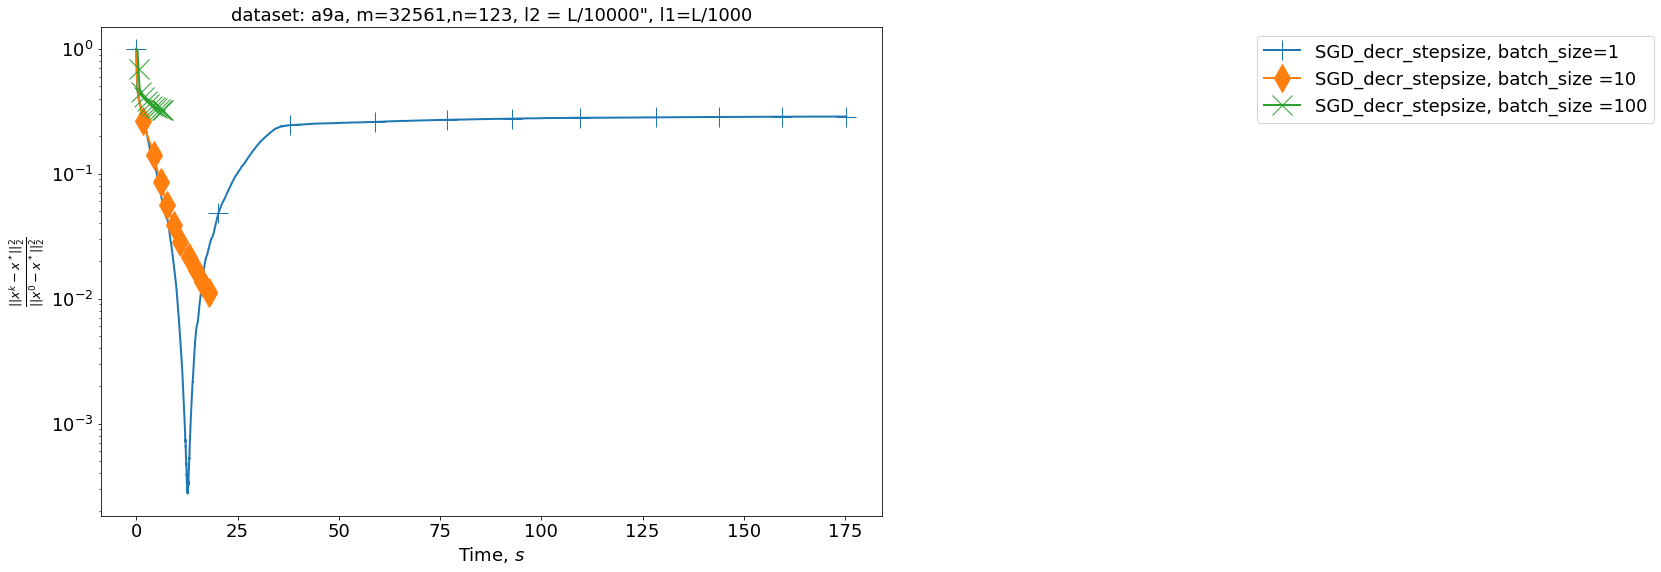

In [26]:
r1 = 1
r2 = 10
r3 = 100
schedule = [gamma, 10, 0.8]

filename=dataset
l2 = L / 10000
l1 = L / 1000
S = 100
save_info_period = 100

methods = [
        ['SGD_decr_stepsize', [schedule, l2, l1, S, r1], 
           f', batch_size={r1}', None],
        ['SGD_decr_stepsize', [schedule, l2, l1, S, r2], 
           f', batch_size ={r2}', None], # r_10 = 10, schedule = [gamma, 10, 0.8], S=100, l2 = L / 10000, l1 = L / 1000
        ['SGD_decr_stepsize', [schedule, l2, l1, S, r3], 
           f', batch_size ={r3}', None],
]
mode_y = 'squared_distances'
mode_x = 'time'
figsize = (14, 9)
fontsize = 18
# title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))
title = f'dataset: {dataset}, m={m},n={n}, l2 = L/{str(int(L/l2))}", l1=L/{str(int(L/l1))}'

args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args=args_for_plots)
plt.show()

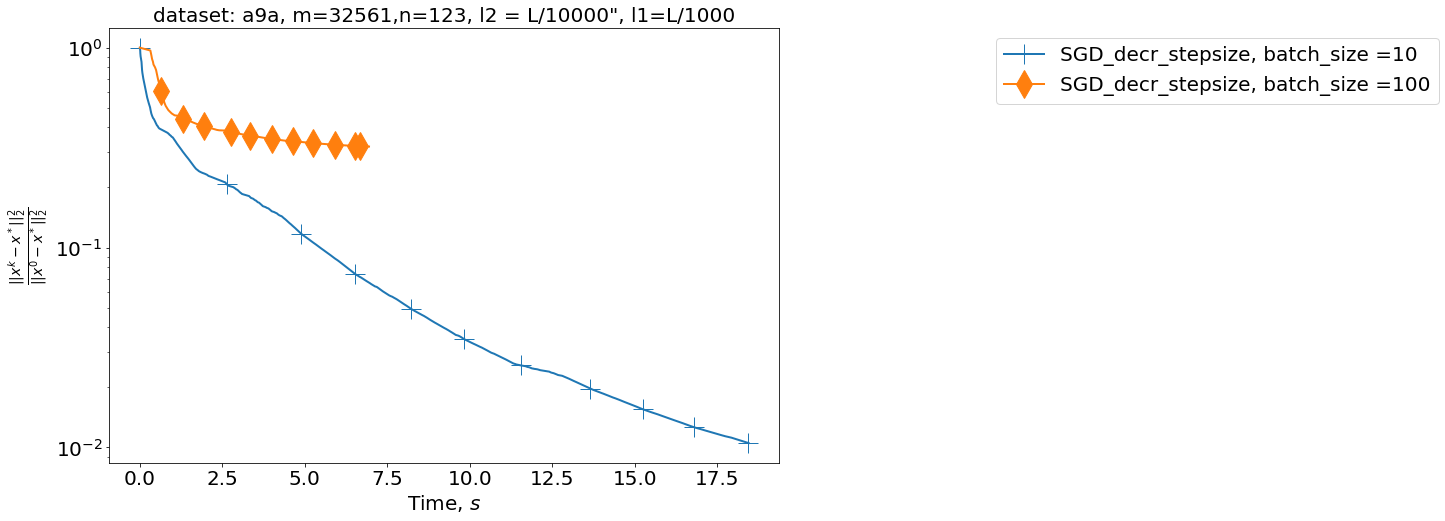

In [27]:
r1 = 10
r2 = 100
schedule = [gamma, 10, 0.8]

filename=dataset
l2 = L / 10000
l1 = L / 1000
S = 100
save_info_period = 100

methods = [
        ['SGD_decr_stepsize', [schedule, l2, l1, S, r1], 
           f', batch_size ={r1}', None],
        ['SGD_decr_stepsize', [schedule, l2, l1, S, r2], 
           f', batch_size ={r2}', None],
]
mode_y = 'squared_distances'
mode_x = 'time'
figsize = (12, 8)
fontsize = 20
title = f'dataset: {dataset}, m={m},n={n}, l2 = L/{str(int(L/l2))}", l1=L/{str(int(L/l1))}'

args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args=args_for_plots)
plt.show()

## Задание 5. prox-GD, FISTA и GD

Имплементируйте $\texttt{prox-GD}$, $\texttt{FISTA}$ и $\texttt{GD}$

In [ ]:
filename=dataset+"_x_init_all_ones"
x_init = np.ones(n)
l2 = L / 10000
l1 = L / 1000
gamma = 1.0/((L+l2))
x_star = None
f_star = None
S = 1000
save_info_period = 10

#этото параметр выставите в соответствии с вашими экспериментами по разреженности матрицы
sparse = True

In [ ]:
%%time
res = prox_gd(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse=sparse, l1=l1, S=S, max_t=np.inf,
     save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

Запустите функцию, тестирующую корректность работы

In [ ]:
prox_gd_test(res)

In [ ]:
filename=dataset+"_x_init_all_ones"
x_init = np.ones(n)
l2 = L / 10000
l1 = L / 1000
x_star = None
f_star = None
S = 1000
save_info_period = 10

#этот параметр выставите в соответствии с вашими экспериментами по разреженности матрицы
sparse = True

In [ ]:
%%time
res = FISTA(filename=filename, x_init=x_init, A=A, y=y, L=L+l2, mu=l2, 
     sparse=sparse, l1=l1, S=S, max_t=np.inf,
     save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

Запустите функцию, тестирующую корректность работы

In [ ]:
fista_test(res)

In [ ]:
filename=dataset+"_x_init_all_ones"
x_init = np.ones(n)
l2 = L / 10000
l1 = L / 1000
gamma = 1.0/((L+l2))
x_star = None
f_star = None
S = 1000
save_info_period = 10

#этото параметр выставите в соответствии с вашими экспериментами по разреженности матрицы
sparse = True

In [ ]:
%%time
res = gd(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse=sparse, l1=l1, S=S, max_t=np.inf,
     save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

Запустите функцию, тестирующую корректность работы

In [ ]:
gd_test(res)

Если тесты пройдены успешно, то выполните эксперименты, описанные в задании.

## Задание 6. Сравнение методов

## Задание 7. Эксперименты с другим датасетом